In [5]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import math
import itertools as itool

In [1]:
class BoundaryCondition:
    RBC, PBC = range(2)
    
class StartConf:
    Triangular, Rectangular, Random, Confined = range(4)
    

In [2]:
class particle2(object):

    def __init__(self, mass=1., x=0., y=0., vx=0., vy=0.):
        self.mass = mass
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.fx = 0.
        self.fy = 0.
       
    def euler(self, fx, fy, dt):
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        self.x = self.x + self.vx*dt
        self.y = self.y + self.vy*dt
        
    def accel(self, dt):
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        
    def move(self, dt, dt2half):
        self.x = self.x + self.vx*dt + self.fx/self.mass*dt2half
        self.y = self.y + self.vy*dt + self.fy/self.mass*dt2half

In [58]:
class MDsystem(object):

    def __init__(self, lx, ly, N, dt, bc): 
        self.N = N
        self.lx = ly
        self.ly = lx
        self.dt = dt
        self.dt2 = dt*dt
        self.dthalf = dt * 0.5
        self.dt2half = self.dt2 * 0.5
        self.bc = bc
        self.particles = [particle2()]
        for i in range(1,N):
            self.particles.append(particle2()) # we create a list of N particles

    def init(self, config, vmax):
        np.random.seed(1272121) # arbitrary seed
        nrows = int(math.sqrt(self.N)*float(self.ly)/float(self.lx))
        ncols = int(math.sqrt(self.N)*float(self.lx)/float(self.ly))
        ax = float(lx) / float(ncols)
        ay = float(ly) / float(nrows)
        i = 0

        if config == StartConf.Triangular:
            #Challenge
            nrows = int(math.sqrt(self.N))
            ncols = int(nrows)
            ax = float(lx)/float(ncols)
            ay = float(ly)/float(nrows)
            for row, col in itool.product(range(nrows),range(ncols)):
                self.particles[i].x = col*ax+ax/2.
                if row%2 == 1:
                    self.particles[i].x += ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1
        elif config == StartConf.Rectangular:
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1

            for row, col in itool.product(range(1,nrows),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.+ax/4.
                self.particles[i].y = row*ay+ay/2.+ay/4.
                i+=1
                
        elif config == StartConf.Confined:
            ax /= 2.
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1

            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.+ax/4.
                self.particles[i].y = row*ay+ay/2.+ay/4.
                i+=1
                
        elif config == StartConf.Random:
            for i in range(self.N):
                overlap = True;
                while overlap:
                    overlap = False;
                    self.particles[i].x = np.random.random()*self.lx
                    self.particles[i].y = np.random.random()*self.ly
                    for j in range(i):
                        r12 = self.distance(self.particle[i], self.particle.p[j])
                        if r12 < 1.: 
                            overlap = True;
                            break
                                
        # Velocities
        for p in self.particles:
            p.vx = vmax*(2. * np.random.random() - 1);
            p.vy = vmax*(2. * np.random.random() - 1);

        # We set total momentum to zero
        vxcm = 0.
        vycm = 0. # Velocity of the center of mass
        for p in self.particles:
            vxcm += p.vx;
            vycm += p.vy;
        
        vxcm /= self.N
        vycm /= self.N
        for p in self.particles:
            p.vx -= vxcm;
            p.vy -= vycm;
            
        self.forces()          
        
    def evolve(self):
        for p in self.particles:
            p.move(self.dt, self.dt2half)
            p.accel(self.dthalf)
            self.boundary(p)

        self.forces()

        for p in self.particles:
            p.accel(self.dthalf)

        
    def distance(self, p, other):
        (r12, dx, dy) = self.distance2(p, other)
        return math.sqrt(r12)

    def distance2(self, p, other):
        dx = other.x - p.x;
        dy = other.y - p.y;


        # nearest image convention
        if self.bc == BoundaryCondition.PBC:
            if abs(dx) > self.lx/2:
                dx -= dx*lx/abs(dx)
                
            if abs(dy) > self.ly/2:
                dy -= dy*ly/abs(dy)
        
        r12 = dx * dx + dy * dy
        return (r12, dx, dy)

    def force(self, p, other):  #Lennard-Jones
        (r12,dx,dy) = self.distance2(p, other)
        r2 = 1./r12
        r6 = r2 * r2 * r2
        f = 24.*r2*r6*(2.*r6-1.)
        fx = f*(-dx)
        fy = f*(-dy)
        return (fx, fy);
      
    def forces(self):
        # Compute the interaction forces between particles
        for p in self.particles:
            p.fx = 0.
            p.fy = 0.
    
        for i in range(self.N):
            p = self.particles[i]
            for j in range(i+1,self.N):
                other = self.particles[j]
                (fx, fy) = self.force(p, other)
                p.fx += fx
                p.fy += fy
                other.fx -= fx
                other.fy -= fy

    def boundary(self, p):
        if self.bc == BoundaryCondition.RBC:
            
            if p.x < 0:  
                p.x = -p.x
                p.vx = -p.vx
            if p.y < 0:
                p.y = -p.y
                p.vy = -p.vy
            if p.x > self.lx:
                p.x = 2*self.lx - p.x
                p.vx = -p.vx
            if p.y > self.ly:
                p.y = 2*self.ly - p.y
                p.vy = -p.vy

        elif self.bc == BoundaryCondition.PBC:

            if p.x < 0: 
                p.x += lx
            elif p.x > lx:  
                p.x -= lx
            if p.y < 0:  
                p.y += ly
            elif p.y > ly:  
                p.y -= ly
#            c = (p.x+2*self.lx)/self.lx
#            p.x = p.x + 2*self.lx - int(c)*self.lx
#            c = (p.y+2*self.ly)/self.ly
#            p.y = p.y + 2*self.ly - int(c)*self.ly

    def LJ_potential(self,r1,r2):
        if r1 == r2:
            return 0;
        r = self.distance(r1,r2)
        V0 = 1
        a=1
        return 4*V0*((a/r)**12-(a/r)**6)
    

    
    def temperature(self):
        temp = 0
        for p in self.particles:
            temp += p.vx**2 +p.vy**2
            
        temp = temp/ self.N
        return temp/2
    
    def scale(self,v):
        for p in self.particles:
            p.vx = p.vx*v
            p.vy = p.vy*v
    
    
    def kinetic_energy(self): # Challenge
        ke = 0;
        for p in self.particles:
            ke = ke + (0.5) * ( p.vx**2 + p.vy**2 )
        return ke
    
    def pot_energy(self): # Challenge
        pe = 0;
        
        
        for i in range(self.N):
            for j in range(self.N)[i+1:]:
                pe = pe + self.LJ_potential(self.particles[i],self.particles[j])
        return pe
    
    def total_energy(self):
        return self.kinetic_energy()+self.pot_energy()


In [28]:
lx = 8
ly = 8
N = 12
dt = 0.001
vmax = 1

T_scale = [1,2,4]
step1 = 50;
step2 = 10
T_array = {}
T_array2 = {}

for m in T_scale:
    S = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
    S.init(StartConf.Confined, vmax)
    T_array[m] = []    
    for l in range(step2):
        T = 0
        for j in range(step1):
            S.evolve()
            T += S.temperature()
        T_real = T/step1
        
        v = np.sqrt(m/T_real)
        S.scale(v)
        T_array[m].append(T_real)
    print(S.temperature())
    temps = []
    T_array2[m] = []
    for i in range(1000):
        S.evolve()
        temps.append( S.temperature() )
        s = np.sqrt( m/S.temperature() )
        S.scale(s)
    for i in range(len(temps)):
        T_array2[m].append( np.mean( temps[i:i+5] ) )



   



0.9839649631487806
2.0500651044519516
4.276018122592151


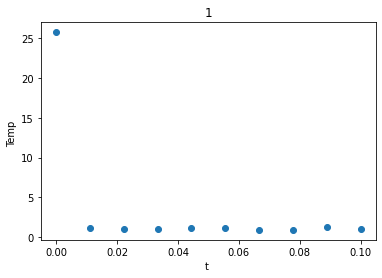

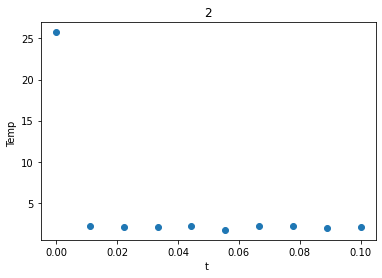

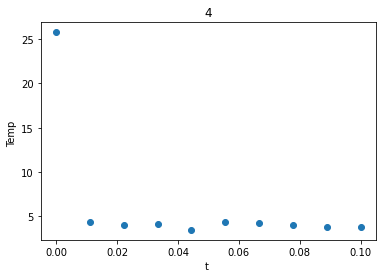

In [29]:
for i in T_array:
    t = np.linspace(0,len(T_array[i])*dt*step2,len(T_array[i]))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(t,T_array[i])

    plt.title(str(i))
    plt.xlabel("t ")
    plt.ylabel("Temp ")

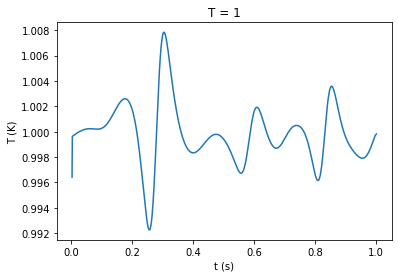

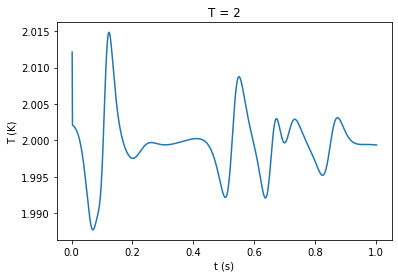

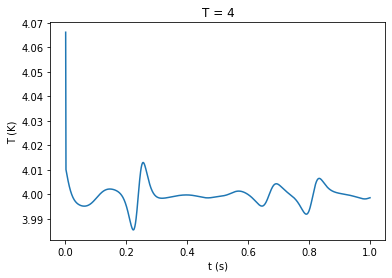

In [63]:
for k in T_array2:
    mean = np.arange( len(T_array2[k])+5 )*dt
    t = np.array( [ np.mean( mean[i:i+5] ) for i in range(len(mean)-5) ] )
    graph = plt.figure()
    ax = graph.add_subplot(111)
    ax.plot(t, T_array2[k])
    plt.title("T = "+str(k))
    plt.xlabel("t (s)")
    plt.ylabel("T (K)")
    plt.show()


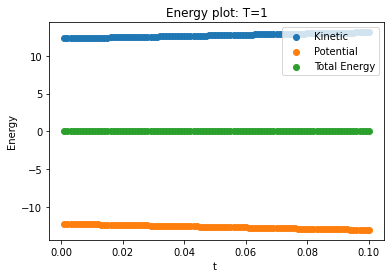

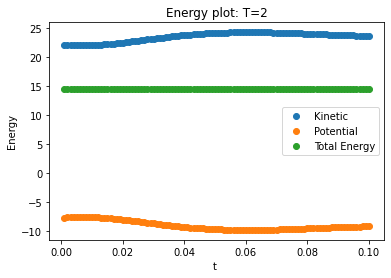

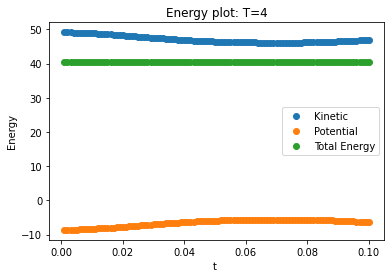

In [61]:
#This part is to determine total energy and plot versus time interval
Lx = 8
Ly = 8
dim = 2
N = 12
v0 = 1
dt = 0.001
T_scale = [1,2,4]

step1 = 10
step2 = 100

for m in T_scale:
    S = MDsystem(Lx, Ly, N, dt, BoundaryCondition.PBC)
    S.init(StartConf.Confined, v0 )
    K = []
    P = []
    E = []
    time_array = []
    
    for j in range(step1):
        
        
        T = 0
        for k in range(step2):
            S.evolve()
            T += S.temperature()
        
       
        T_real = T/step2
        v = np.sqrt( m/T_real )
        S.scale(v)
    
    
    for i in range(100):
        S.evolve()
        time_array.append(dt*(i+1))
        K.append( S.kinetic_energy() )
        P.append( S.pot_energy() )
        E.append(S.total_energy() )
   
    fig = plt.figure()
    graph = fig.add_subplot(111)
    graph.scatter(time_array,K,label="Kinetic")
    graph.scatter(time_array,P,label="Potential")
    graph.scatter(time_array,E,label = "Total Energy")
    plt.title("Energy plot: T=" + str(m))
    plt.xlabel("t ")
    plt.ylabel("Energy")
    plt.legend()